# Scan analysis

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import copy

import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
)
from optuna.samplers import TPESampler

from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import (
    get_dispersal_kernel, trait_vec, beta_dist,
    gamma_dist, find_beta_vectorised, score_for_this_df
)
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [64]:
optuna.logging.set_verbosity(0)

## Conclusions:

For low dose:
- high curvature good
- high b good
- think want high mu

Need to be careful that curvature not so high that it stays too flat initially, or that dose response looks silly 

Something like this looks decent:

```
cf = get_asymptote_config(
    verbose=False,
    n_k=100,
    n_years=30,              
    k_mu=0.96,
    k_b=2,
    curvature=20
)
```



Next steps:

- try fitting to Frank data (quickly)
- see what that model does, if crap then try custom parameters to demonstrate effect
- hope for something which fairly consistently gives high doses best
- probably show that range of outcomes possible again

In [79]:
class FungicideObjective:
    def __init__(self) -> None:
        """Fit fungicide distribution parameters

        Parameters
        ----------
        config : Config
            See Config docs - type 'single'
        """
        
        TRAIN_TEST_SPLIT_PROPORTION = 2/3

        self.df = (
            pd.read_csv(
                '../data/control_prothio_with_uncertainty.csv'
            )
            .loc[lambda df: (
                df.year <= (
                    df.year.min() - 1
                    + TRAIN_TEST_SPLIT_PROPORTION *
                    (1 + df.year.max() - df.year.min())
                )
            )
            ]
            .rename(columns={
                'control_with_noise_t': 'data_control',
            })
        )

        n_years = len(self.df.year.unique())

        input_severities = [0.37] * n_years

        self.input_severities = input_severities
        
        cf = get_asymptote_config(
            verbose=False,
            n_k=300,
            n_years=n_years,
            k_mu=None,
            k_b=None,
            curvature=None
        )
        
        cf.betas = find_beta_vectorised(input_severities, cf.I0s[0])
        
        cf.print_repr()

        self.config = cf

    #
    #

    def __call__(self, trial):

        params = self.get_params(trial)

        control = self.run_model(params)

        return score_for_this_df(self.df, control)

    #
    #

    def run_model(self, params):

        NOT_USED_NUM = 0.5

        sevs_trait_off = np.asarray(self.input_severities)

        conf_use = copy.deepcopy(self.config)
        conf_use.k_mu = params['mu']
        conf_use.k_b = params['b']
        conf_use.curvature = params['curvature']

        output = (
            SimulatorAsymptote(conf_use, number_of_sprays=1)
            .run_model()
        )

        sevs_trait_on = np.asarray(output['dis_sev'])

        control = 100 * (1 - sevs_trait_on / sevs_trait_off)

        return control

    #
    #

    def get_params(self, trial):
        params = {
            "mu": trial.suggest_float("mu", 1e-2, 1),
            "b": trial.suggest_float("b", 1e-3, 30),
            "curvature": trial.suggest_float("curvature", 1e-2, 30),
        }
        return params

In [80]:
sampler = TPESampler(seed=0)
study = optuna.create_study(sampler=sampler)
obj_f = FungicideObjective()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00877344, 0.00877344, 0.00877344, 0.008 ...
curvature = None
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
k_b = None
k_mu = None
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
n_k = 300
n_years = 12
sprays = None



In [106]:
%%time

study.optimize(obj_f, n_trials=20)
int(study.best_value)

Wall time: 1min 53s


738665

In [107]:
%%time

study.optimize(obj_f, n_trials=20)
int(study.best_value)

Wall time: 1min 45s


710641

In [108]:
%%time

study.optimize(obj_f, n_trials=100)
int(study.best_value)

Wall time: 8min 53s


692231

# Plot opt

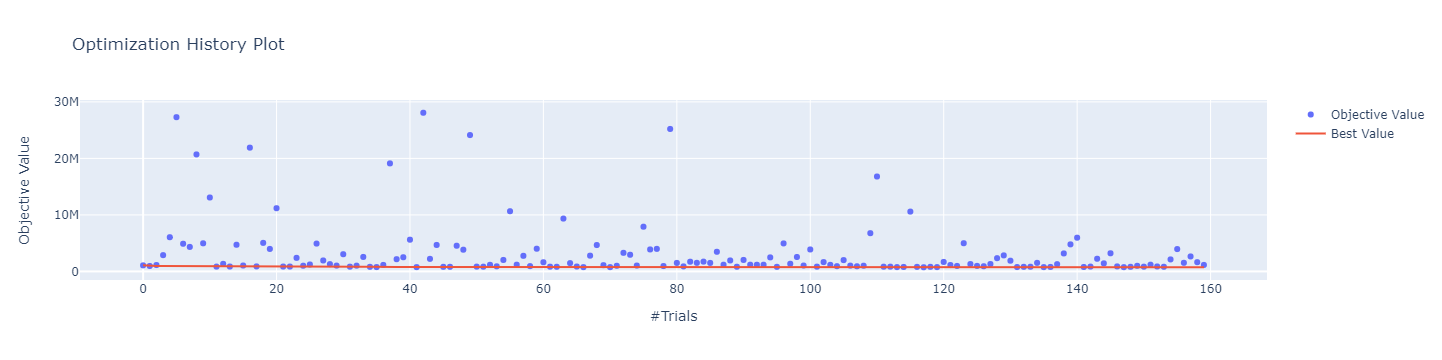

In [101]:
plot_optimization_history(study)

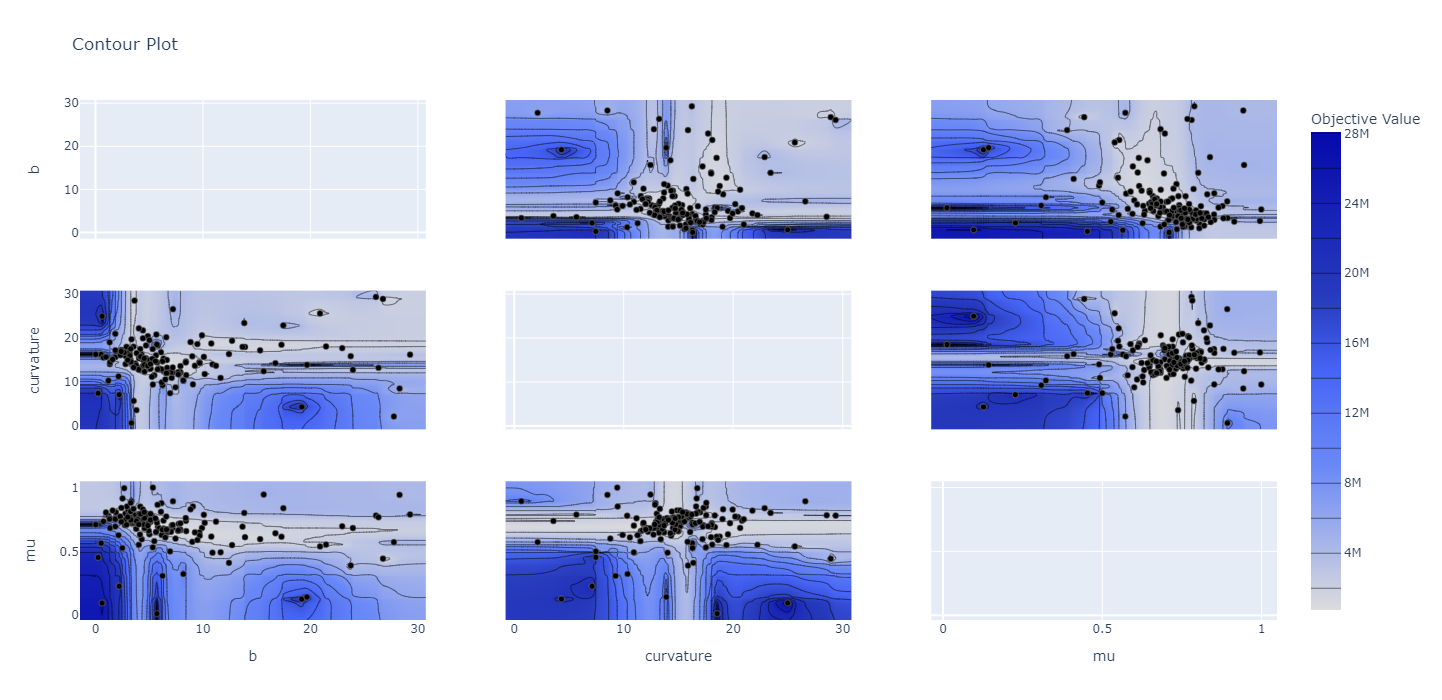

In [102]:
fig = plot_contour(study)

fig.update_layout(height=700)

# Plot output

In [103]:
best_pars = study.best_params
best_pars

{'mu': 0.7537152707909325,
 'b': 3.9310391352531706,
 'curvature': 13.1161191359555}

In [104]:
out = obj_f.run_model(best_pars)

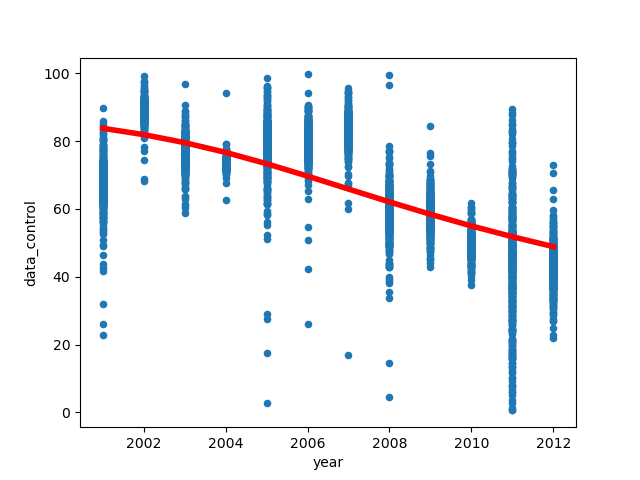

In [105]:
f, ax = plt.subplots()

obj_f.df.plot.scatter(x='year', y='data_control', ax=ax)

ax.plot(obj_f.df.year.unique(), out, c='r', lw=4)